In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.covariance import EllipticEnvelope
import collections
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [3]:
data = pd.read_csv('CSC215_P2_Stock_Price.csv')
data.drop(['Date','Adj_Close'], axis=1, inplace=True)
data

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600
...,...,...,...,...,...
4387,113.790001,114.099998,112.790001,113.309998,950000
4388,112.519997,113.529999,111.160004,111.870003,1805200
4389,112.029999,112.489998,110.250000,112.230003,2136700
4390,112.459999,112.900002,112.000000,112.339996,1251600


In [4]:
data['y'] = data['Close']
data

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625
...,...,...,...,...,...,...
4387,113.790001,114.099998,112.790001,113.309998,950000,113.309998
4388,112.519997,113.529999,111.160004,111.870003,1805200,111.870003
4389,112.029999,112.489998,110.250000,112.230003,2136700,112.230003
4390,112.459999,112.900002,112.000000,112.339996,1251600,112.339996


In [5]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    

In [6]:
def to_sequences(seq_size, data1, data2):
    x = []
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [7]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [8]:
encode_numeric_zscore(data,'Open')
encode_numeric_zscore(data,'High')
encode_numeric_zscore(data,'Low')
encode_numeric_zscore(data,'Close')
#encode_numeric_zscore(data,'Adj Close')
encode_numeric_zscore(data,'Volume')

In [9]:
data

,Open,High,Low,Close,Volume,y
0,-0.894209,-0.885022,-0.892306,-0.884364,1.104812,4.125000
1,-0.883762,-0.886056,-0.885975,-0.888021,-0.497301,4.015625
2,-0.887941,-0.889159,-0.887558,-0.888543,-0.892217,4.000000
3,-0.887941,-0.890194,-0.891251,-0.893768,-0.000263,3.843750
4,-0.896820,-0.898986,-0.906551,-0.908920,3.729366,3.390625
...,...,...,...,...,...,...
4387,2.782154,2.754177,2.787407,2.766603,-0.575988,113.309998
4388,2.739700,2.735310,2.732368,2.718452,-0.048610,111.870003
4389,2.723320,2.700885,2.701641,2.730490,0.155816,112.230003
4390,2.737694,2.714457,2.760732,2.734168,-0.390000,112.339996


In [10]:
y = data[['y']].copy()
x = data.drop(['y'], axis = 1)

In [11]:
y

,y
0,4.125000
1,4.015625
2,4.000000
3,3.843750
4,3.390625
...,...
4387,113.309998
4388,111.870003
4389,112.230003
4390,112.339996


In [12]:
x.shape,y.shape

((4392, 5), (4392, 1))

In [13]:
x = np.array(x, dtype=np.float32)
y = np.array(data['y'].values, dtype=np.float32)

In [14]:
y.shape,x.shape

((4392,), (4392, 5))

In [15]:
SEQUENCE_SIZE = 7
x_cnn, y_cnn = to_sequences(SEQUENCE_SIZE,x,y)

In [16]:
x_cnn.shape,y_cnn.shape

((4385, 7, 1, 5), (4385,))

In [17]:
x_cnn.shape[0]

4385

In [23]:
x_cnn= x_cnn.reshape(x_cnn.shape[0],1,5,7)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_cnn, y_cnn, test_size=0.25, random_state=33)

In [25]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3288, 1, 5, 7), (1097, 1, 5, 7), (3288,), (1097,))

In [28]:
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
model_cnn = Sequential()
model_cnn.add(Conv2D(256, kernel_size=(1,5), strides=(1, 1), padding='valid',input_shape=(1,5,7), activation ="relu"))
model_cnn.add(MaxPooling2D(pool_size=(1,1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation ="relu"))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
model_cnn.summary()

t1 = datetime.now()
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_relu.hdf5", verbose=0, save_best_only=True) # save best model
history = model_cnn.fit(x_train, y_train, validation_data= (x_test, y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model_cnn.load_weights('best_weights_cnn_relu.hdf5') # load weights from best model

train_time = datetime.now() - t1



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 1, 256)         9216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 25,729
Trainable params: 25,729
Non-trainable params: 0
__________________________________________________

Score_train (RMSE): 1.4876312017440796
Score_test (RMSE): 1.7661901712417603


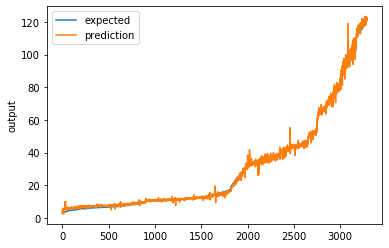

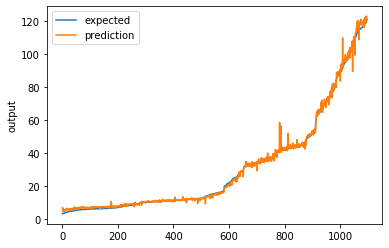

In [29]:

pred_train = model_cnn.predict(x_train)
pred_test = model_cnn.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
print("Score_train (RMSE): {}".format(rmse))
rmse = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
print("Score_test (RMSE): {}".format(rmse))

#regression lift Chart
chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)